## Frozen Lake

The Frozen Lake environment is an uncertain grid world in which one starts from an initial state (the topmost square on the left) to go to a final state (the bottommost square on the right). The environment is uncertain as you are walking on a frozen lake and the ice thickness varies. You can therefore fall into the water in certain squares. Also, the ice is more slippery in some places, so taking a step can take you farther than expected...and if the wind picks up...

Instead of trying to estimate the transition model, we will use SARSA and Q-learning to solve this problem.

Use the Frozen Lake environment to implement SARSA and Q-learning. First use the environment with a 4x4 grid to test your algorithms, then you should be able to use them for the 16x16 grid.

------------------------------------------------------------------

Lingkungan Danau Beku adalah dunia kisi yang tidak pasti di mana seseorang memulai dari keadaan awal (kotak paling atas di sebelah kiri) untuk menuju ke keadaan akhir (kotak paling bawah di sebelah kanan). Lingkungan tidak pasti saat Anda berjalan di danau beku dan ketebalan es bervariasi. Karena itu Anda dapat jatuh ke air di kotak tertentu. Selain itu, esnya lebih licin di beberapa tempat, jadi mengambil langkah dapat membawa Anda lebih jauh dari yang diharapkan...dan jika angin kencang...

Alih-alih mencoba memperkirakan model transisi, kami akan menggunakan SARSA dan Q-learning untuk menyelesaikan masalah ini.

Gunakan lingkungan Frozen Lake untuk mengimplementasikan SARSA dan Q-learning. Pertama gunakan lingkungan dengan kisi 4x4 untuk menguji algoritme Anda, lalu Anda harus dapat menggunakannya untuk kisi 16x16.



In [5]:
# pip install moviepy

In [6]:
#pip install gym[toy_text]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random
import gym
from tqdm.notebook import tqdm
import os
from moviepy.editor import ImageSequenceClip
from IPython.display import Image
from collections import defaultdict



# FrozenLake - environmental familiarization

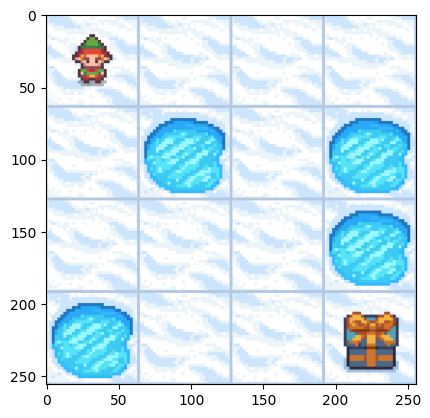

In [8]:

env = gym.make("FrozenLake-v1",render_mode="rgb_array",is_slippery=True)

env.reset()
plt.imshow(env.render())


In [9]:
#states
numStates = env.observation_space.n
print("there are ", numStates, "states\n")

#actions
numActions = env.action_space.n
print("There is ", numActions, "actions")
print("0: LEFT \n1: DOWN \n2: RIGHT \n3: UP) \n")

#reward:
rewards=env.reward_range
print("rewards:",rewards)
print("Reach goal(G): +1 \nReach hole(H): 0\nReach frozen(F): 0\n")

#matrice de transition 
print("{action: P[s’], s’, r, done }")
print(env.env.P[0])

there are  16 states

il y a  4 actions
0: LEFT 
1: DOWN 
2: RIGHT 
3: UP) 

rewards: (0, 1)
Reach goal(G): +1 
Reach hole(H): 0
Reach frozen(F): 0

{action: P[s’], s’, r, done }
{0: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False)], 1: [(0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False)], 2: [(0.3333333333333333, 4, 0.0, False), (0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False)], 3: [(0.3333333333333333, 1, 0.0, False), (0.3333333333333333, 0, 0.0, False), (0.3333333333333333, 0, 0.0, False)]}


In [10]:
def encode(state):
    return state
def decode(state):
    return state

### random strategy

In [11]:
#strategie
def strategie_aleatoire():
    return(random.choice([0,1,2,3]))

In [12]:
def evaluer_aleatoire(nbr=1000):
    nbr=0
    obs_i, _ =env.reset()
    done=False
    frame=[]
    
    while not done:
        action=random.choice([0,1,2,3])
        obs_j, reward, done,_,_=env.step(action)
        frame.append(env.render())
        nbr=nbr+1
    print("Episode ended after {} iterations".format(nbr))
    print("Average Achieved Rewards:",reward)
    clip=ImageSequenceClip(frame, fps=10).resize(1.0)
    clip.write_gif("rozenLake_Rate_Randomly.gif", fps=10)

Episode terminé après 13 itérations
Récompenses obtenues moyenne: 0.0
MoviePy - Building file FrozenLake_evaluer_alea.gif with imageio.


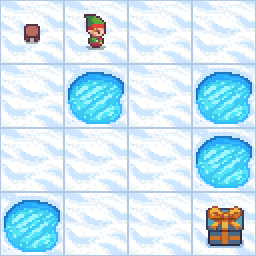

In [13]:
evaluer_aleatoire()
Image(filename="FrozenLake_Rate_Randomly.gif")

### 1) $\epsilon$-greedy

Implement a function that returns an action with the $\epsilon$-greedy strategy:
* exploits with probability $1-\epsilon$: here we choose the action with the best value of $q[s]$
* explores with a probability $\epsilon$: we choose an action in a uniform way on all the actions.

You can choose different signature for the function:
or by passing it:
  * the parameter $\epsilon$
  * the `Q` table
  * the `s` state in which the action will be executed
  * so the call will have the form `action = epsGreedy(eps, Q, s)`

  Another solution, you can give only the value of $\epsilon$ and vector Q(s) (which has for dimension the number of actions). The call will therefore have the form `action = epsGreedy(eps, q)`

*Warning* We can imagine the particular case where we find several occurrences of the value max in the vector `Q(s)`. In this case, you should not *always* choose the same action, but rather choose one of the ex-aequo actions at random.
This case may not be so exotic, especially at the beginning of learning, when all the values are null. To explore, it is then desirable to repeat the same choice!


For those unfamiliar with python, take a look at the small sample code below to illustrate some functions of the `numpy` library
- The `np.random.rand()` function draws a value uniformly between 0 and 1.
- The np.random.choice function allows you to uniformly choose a value from a set.
- The `np.argwhere(l)` function is used to give the indices where the entry of the vector l is non-zero. We can therefore couple a call to `np.argwhere` with a test.

In [14]:
import random
# on fait l'hypothèse que pi est un vecteur numpy de taille le nombre 
# d'actions disponible
def draw(q_s):
    i=np.random.choice(len(q_s),1, p=q_s)[0]
    return i
def epsGreedy(epsilon, q_s):
    x = random.uniform(0,1)
    if x<epsilon:
        return(draw(np.ones(len(q_s))*(1/len(q_s))))
    else:
        argmax=q_s==max(q_s)
        return(draw(np.array([1/sum(argmax) if argmax[k] else 0 for k in range(len(q_s))])))

### 2) Test a policy

When learning, it is necessary to explore, so when analyzing performance during learning, it must be borne in mind that part of the choices are made at random. After having learned, we can do a test while being greedy: at each state, we always choose the action which gives the highest value of `Q`.
Implement a method that takes a fixed number of episodes, a `Q` table, and executes the greedy policy. The method returns the average value of the sum of rewards over the episode.

In [15]:
def policy_evaluation(q,gamma,nbr=1000,nombre_iteration=False,gif=False):
    s=0
    if nombre_iteration : k=0
    if gif :frame=[]
    for i in range(nbr):
        obs_i, _ =env.reset()  # initializing the env and extract the initial state 
        #recupere l'image
        if (i==0) and  gif :frame.append(env.render())

        done=False
        G=0
        h=0
        while not done:
            obs_j, reward, done,_,_=env.step(epsGreedy(0, q[encode(obs_i)]))
            #recuperer l'image
            if (i==0) and  gif :frame.append(env.render())
            obs_i=obs_j
            G=G+reward*pow(gamma,h)
            h=h+1
        if nombre_iteration : k=k+h
        s=s+G
    s=s/nbr
    if nombre_iteration and gif : 
        k=k//nbr
        return [s,k,frame]
    elif nombre_iteration:
        k=k//nbr
        return[s,k]
    else:
        return s  

### 3) visualisation

In [16]:
# visualisation de la table Q pour FrozenLake 4x4 et 8x8
# passez la taille (4 ou 8) en paramètres
def plotQ(q_table, map_size):
    
  if (map_size==4):
    MAP = [
        "SFFF",
        "FHFH",
        "FFFF",
        "HFFG"
    ]
  else:
    MAP=[
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ]
  best_value = np.max(q_table, axis = 1).reshape((map_size,map_size))
  best_policy = np.argmax(q_table, axis = 1).reshape((map_size,map_size))
    
  fig, ax = plt.subplots()
  im = ax.imshow(best_value)

  for i in range(best_value.shape[0]):
      for j in range(best_value.shape[1]):
          if MAP[i][j] in 'GH':
              arrow = MAP[i][j]
          elif best_policy[i, j] == 0:
              arrow = '<'
          elif best_policy[i, j] == 1:
              arrow = 'v'
          elif best_policy[i, j] == 2:
              arrow = '>'
          elif best_policy[i, j] == 3:
              arrow = '^'
          if MAP[i][j] in 'S':
              arrow = 'S ' + arrow
          text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
  cbar = ax.figure.colorbar(im, ax = ax)
    
  fig.tight_layout()
  plt.show() 

In [17]:
def plot(q,evaluation,taille=4,plot_Q=True,gamma=1):
    #plot evaluation
    if type(evaluation[0])==np.ndarray:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
        ax1.plot([i * 1000 for i in range(len(evaluation[:,0]))],evaluation[:,0],"r")
        ax1.title.set_text("average gain")
        ax2.plot([i * 1000 for i in range(len(evaluation[:,1]))],evaluation[:,1],"b")
        ax2.title.set_text("number of time steps")                           
    else:
        plt.figure(figsize=(20,7))
        plt.plot([i * 1000 for i in range(len(evaluation))], evaluation,"r")
        plt.xlabel('episode')
        plt.ylabel('average gain')
    plt.show()
    #plotQ only for FrozenLake
    if plot_Q: plotQ(q,taille)
    s,k,frame=policy_evaluation(q,gamma,nbr=1000,nombre_iteration=True,gif=True)
    print("Episode finished after {} average iterations".format(k))
    print("Average obtained rewards:",s)
    return(frame)

### 4) algorithmes

##### a) SARSA

Implement a SARSA function that takes as a parameter
  * a number of episodes used for learning
  * $\gamma$ the discount rate
  * $\alpha$ the learning rate (found when updating Q values)
  * $\epsilon$ the parameter for the $\epsilon$-greedy method.

Your function should at least return the table $Q: S \times A$. You will find below a function $plotQ$ which generates a representation of the table $Q$: for each box will be drawn the best action according to $Q$ and the color will represent the value of this action.
 
To visualize the progress made during training, your SARSA function can also return a sequence of values. For example,
  * the sequence of rewards (total or average) obtained on each learning episode
  * the value of the best action for the starting state at the end of each episode.
  * instead of using the values obtained during training, you can also perform an evaluation of the current policy periodically (without exploration). To do this, you can calculate the performance over a small number of episodes and return the average. This method has the advantage of evaluating the policy without exploration (therefore a better evaluation of the policy), but can be expensive in computing time depending on the frequency of execution and the number of episodes used for the evaluation.

By generating the graph, you should visualize if the algorithm managed to improve performance. You can either directly plot the value of each episode. To have a slightly smoother curve, you can also calculate an average over a window of $k$ episodes (the $runningAvg$ function does this job).

Note that Frozen lake is considered solved when
  * it reaches the goal in 78% of episodes for the 4x4 grid.
  * a priori, we can reach 100% for the 8x8 grid

Some ideas to help with debeug:
  * you can also check if most state-action pairs have been executed.
  * You can choose as parameters (the code I wrote worked with these parameters, obviously you can try with others later).
    * $\epsilon=0.2$
    * $\alpha=0.02$
    * Frozen lake is an episodic task, so here we can simply focus on the sum of the rewards accumulated during an episode. So we can choose $\gamma=1$ (no discount).

In [18]:
def sarsa(gamma,nbr,Nombre_etat,alpha=0.02,eps=0.2,nbr_eval=1000,nbr_iteration=False,eps_variable=False,freq_eval=1000):
    #initialisation
    q = np.zeros((Nombre_etat,env.action_space.n))
    evaluation=[]
    epsilon=eps
    
    for i in tqdm(range(nbr)):
        obs_i,_ = env.reset()
        done=False
        action=epsGreedy(epsilon,q[encode(obs_i)])
        
        while not done:
            obs_j, reward, done,_,_=env.step(action)
            if done:
                q[encode(obs_i)][action]=q[encode(obs_i)][action]+alpha*(reward-q[encode(obs_i)][action])
                if i% freq_eval==0: 
                    evaluation.append(policy_evaluation(q,gamma,nbr_eval,nombre_iteration=nbr_iteration))
                    if eps_variable: epsilon=epsilon*0.99
                    
                break
            else:
                action_=epsGreedy(epsilon,q[encode(obs_j)])
                q[encode(obs_i)][action]=q[encode(obs_i)][action]+alpha*(reward+gamma*q[encode(obs_j)][action_]-q[encode(obs_i)][action])
            obs_i=obs_j
            action=action_
    return(q,evaluation)


##### b) Q-learning

In [19]:
def Q_learning(gamma,nbr,Nombre_etat,alpha=0.02,eps=0.2,nbr_eval=1000,nbr_iteration=False,eps_variable=False,freq_eval=1000):
    #initialisation

    q = np.zeros((Nombre_etat,env.action_space.n))
    evaluation=[]
    epsilon=eps
    
    for i in tqdm(range(nbr)):
        #etat initial
        obs_i,_ = env.reset()
        done=False
        #choisir action a ∈ A (eps-greedy)
        action=epsGreedy(epsilon,q[encode(obs_i)])
        
        while not done:
            #Exécute action a, observe r∈ R et état suivant s'∈ S
            obs_j, reward, done,_,_=env.step(action)
            #si s' est final
            if done:
                #mise a jour
                q[encode(obs_i)][action]=q[encode(obs_i)][action]+alpha*(reward-q[encode(obs_i)][action])
                if i% freq_eval==0: 
                    evaluation.append(policy_evaluation(q,gamma,1000,nombre_iteration=nbr_iteration))
                    if eps_variable: epsilon=epsilon*0.99
                    
                break
            #sinon
            else:
                #mise a jour
                max_action=epsGreedy(0,q[encode(obs_j)])
                q[encode(obs_i)][action]=q[encode(obs_i)][action]+alpha*(reward+gamma*q[encode(obs_j)][max_action]-q[encode(obs_i)][action])
               
                # choisir action a' pour s'(eps-greedy)
                action_=epsGreedy(epsilon,q[encode(obs_j)])
                
            obs_i=obs_j
            action=action_
    return(q,evaluation)


##### c) Monte Carlo on policy

In [20]:
def onPolicyMC(gamma,nbr,Nombre_etat,eps=0.2,nbr_iteration=False,eps_variable=False,freq_eval=1000):
    #initialisation 
    q = np.zeros((Nombre_etat,env.action_space.n))
    count_state_action = defaultdict(lambda: np.zeros(env.action_space.n))#count[s][a]=0 pour tout s et a
    epsilon=eps
    
    evaluation=[]
    
    for i in tqdm(range(nbr)):
        #simuler une episode
        obs_i, _ =env.reset()  
        episode=[] 
        done=False
        while not done:
            action=epsGreedy(epsilon,q[encode(obs_i)])
            obs_j, reward, done,_,_=env.step(action)
            episode.append((encode(obs_i),action,reward))
            #episode=[(s_0,a_0,r_1),(s_1,a_1,r_2)...(S_n-1),a_(n-1),r_n)]
            obs_i=obs_j
        if i%freq_eval==0:
            evaluation.append(policy_evaluation(q,gamma,1000,nombre_iteration=nbr_iteration))
            if eps_variable: epsilon=epsilon*0.99

        G=0
        for s,a,r in reversed(episode):
            new_s_a_count = count_state_action[s][a] + 1
            
            G = r + gamma * G
            count_state_action[s][a] = new_s_a_count
            q[s][a] = q[s][a] + (G - q[s][a]) / new_s_a_count
    return q,evaluation

###  FrozenLake 4x4

###### SARSA

In [21]:
 
q1,evaluation1=sarsa(1,30000,numStates)


  0%|          | 0/30000 [00:00<?, ?it/s]

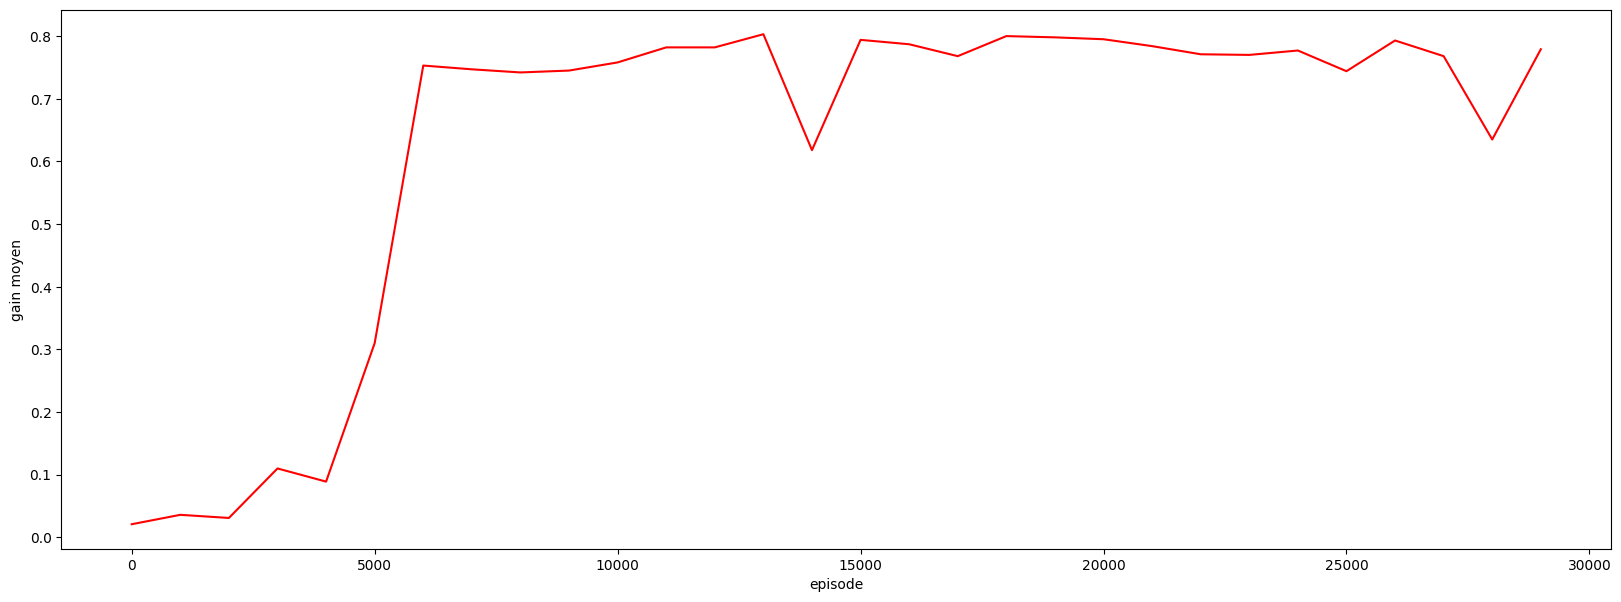

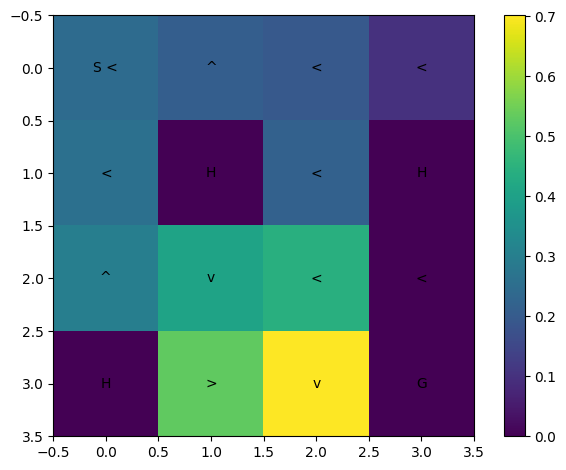

Episode terminé après 43 itérations  moyenne
Récompenses obtenues moyenne: 0.78
MoviePy - Building file FrozenLake_sarsa.gif with imageio.


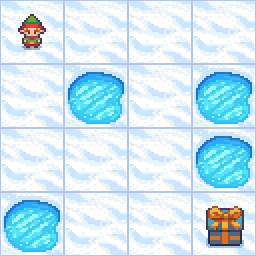

In [22]:
frame=plot(q1,evaluation1,gamma=1)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("FrozenLake_sarsa.gif", fps=10)
Image(filename="FrozenLake_sarsa.gif")

###### Q learning

In [23]:
q2,evaluation2=Q_learning(1,30000,numStates)

  0%|          | 0/30000 [00:00<?, ?it/s]

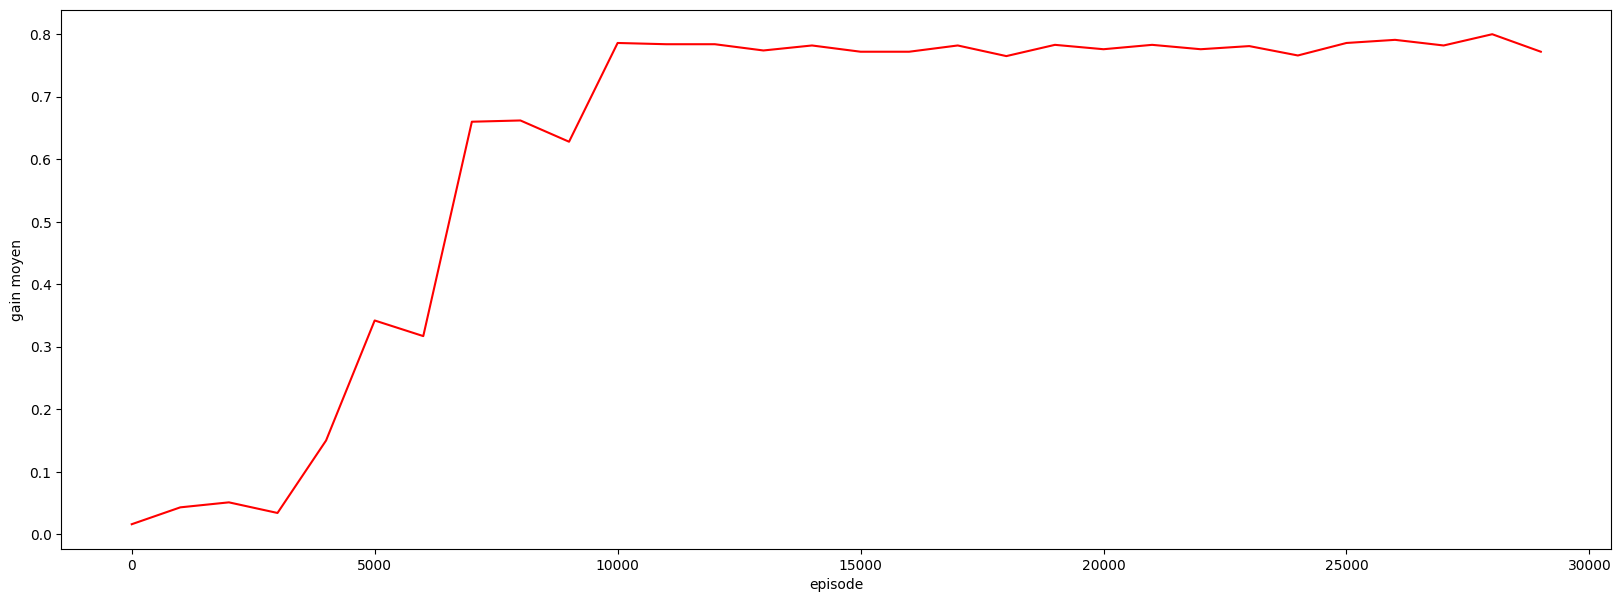

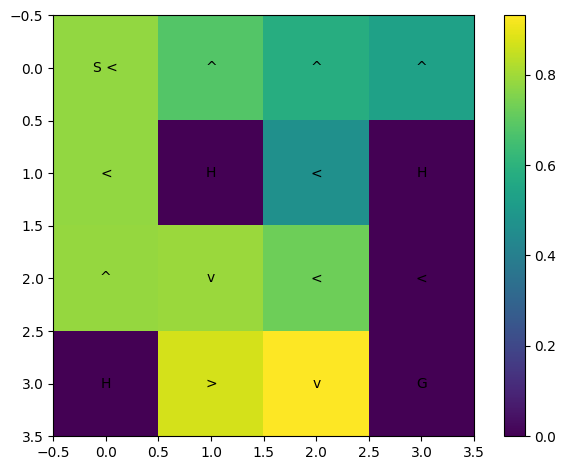

Episode terminé après 48 itérations  moyenne
Récompenses obtenues moyenne: 0.851
MoviePy - Building file FrozenLake_q_learning.gif with imageio.


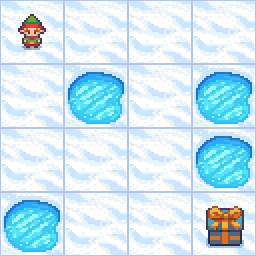

In [24]:
frame=plot(q2,evaluation2)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("FrozenLake_q_learning.gif", fps=10)
Image(filename="FrozenLake_q_learning.gif")

###### on policy

In [25]:
q3,evaluation3=onPolicyMC(1,30000,numStates)

  0%|          | 0/30000 [00:00<?, ?it/s]

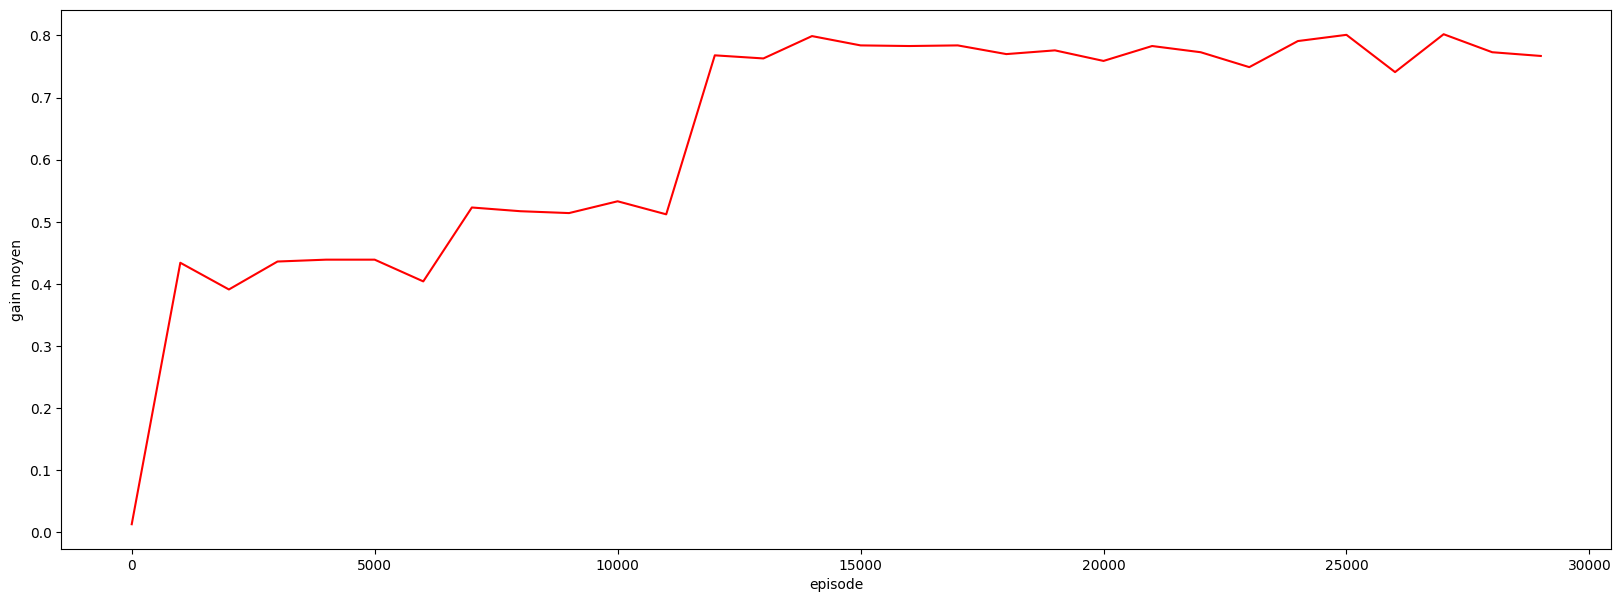

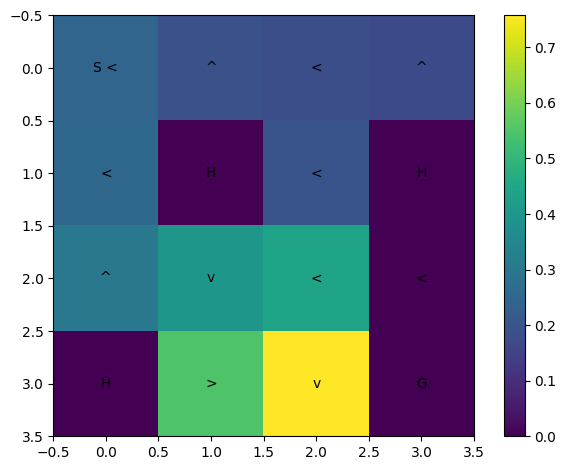

Episode terminé après 43 itérations  moyenne
Récompenses obtenues moyenne: 0.817
MoviePy - Building file FrozenLake_MC.gif with imageio.


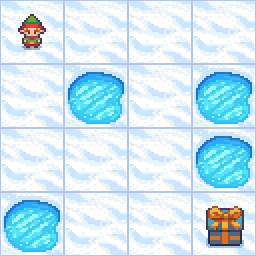

In [26]:
frame=plot(q3,evaluation3)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("FrozenLake_MC.gif", fps=10)
Image(filename="FrozenLake_MC.gif")

### FrozenLake8x8

In [27]:
env.close()
env = gym.make("FrozenLake8x8-v1",render_mode="rgb_array",is_slippery=True)

In [28]:
#states
numStates = env.observation_space.n

###### SARSA

In [29]:
q1_,evaluation1_=sarsa(1,30000,numStates)

  0%|          | 0/30000 [00:00<?, ?it/s]

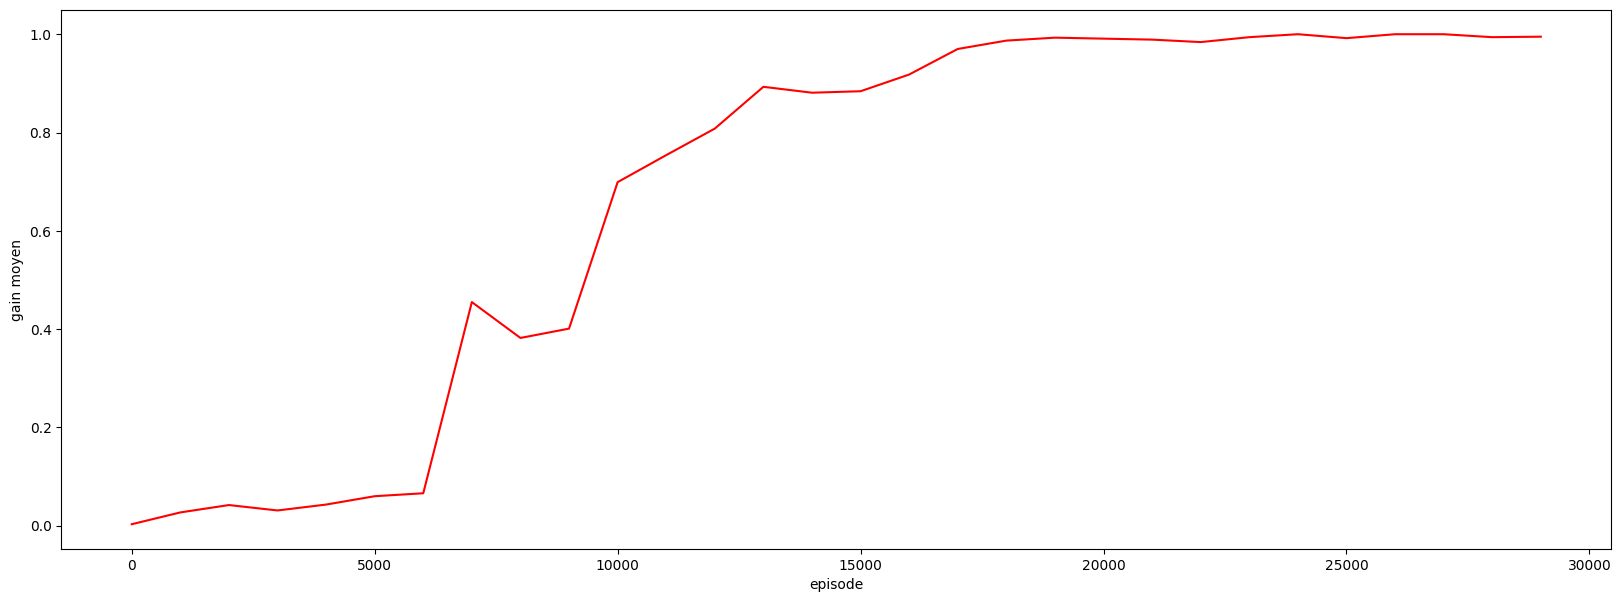

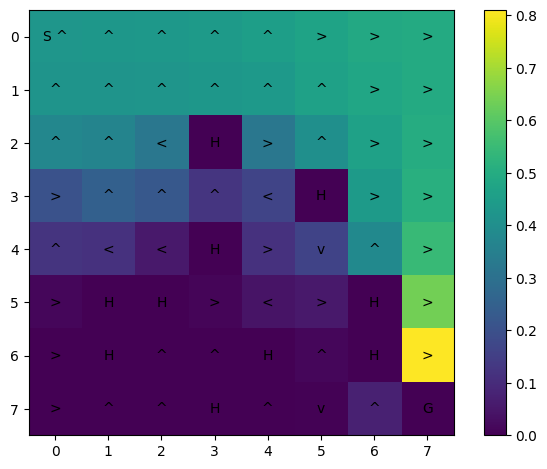

Episode terminé après 137 itérations  moyenne
Récompenses obtenues moyenne: 0.992
MoviePy - Building file FrozenLake_sarsa8x8.gif with imageio.


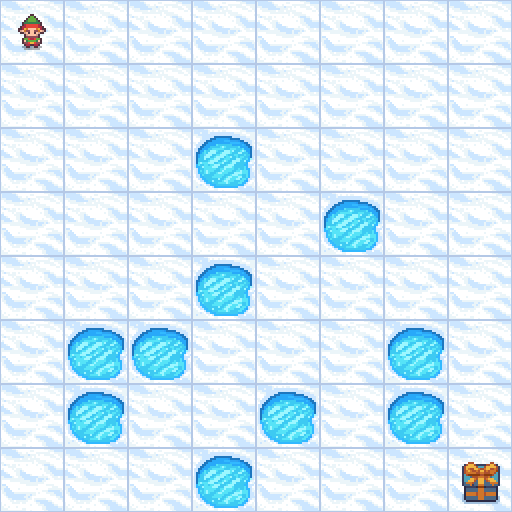

In [30]:
frame=plot(q1_,evaluation1_,8)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("FrozenLake_sarsa8x8.gif", fps=10)
Image(filename="FrozenLake_sarsa8x8.gif")

######  Q_learning

In [31]:
q2_,evaluation2_=Q_learning(1,30000,numStates)

  0%|          | 0/30000 [00:00<?, ?it/s]

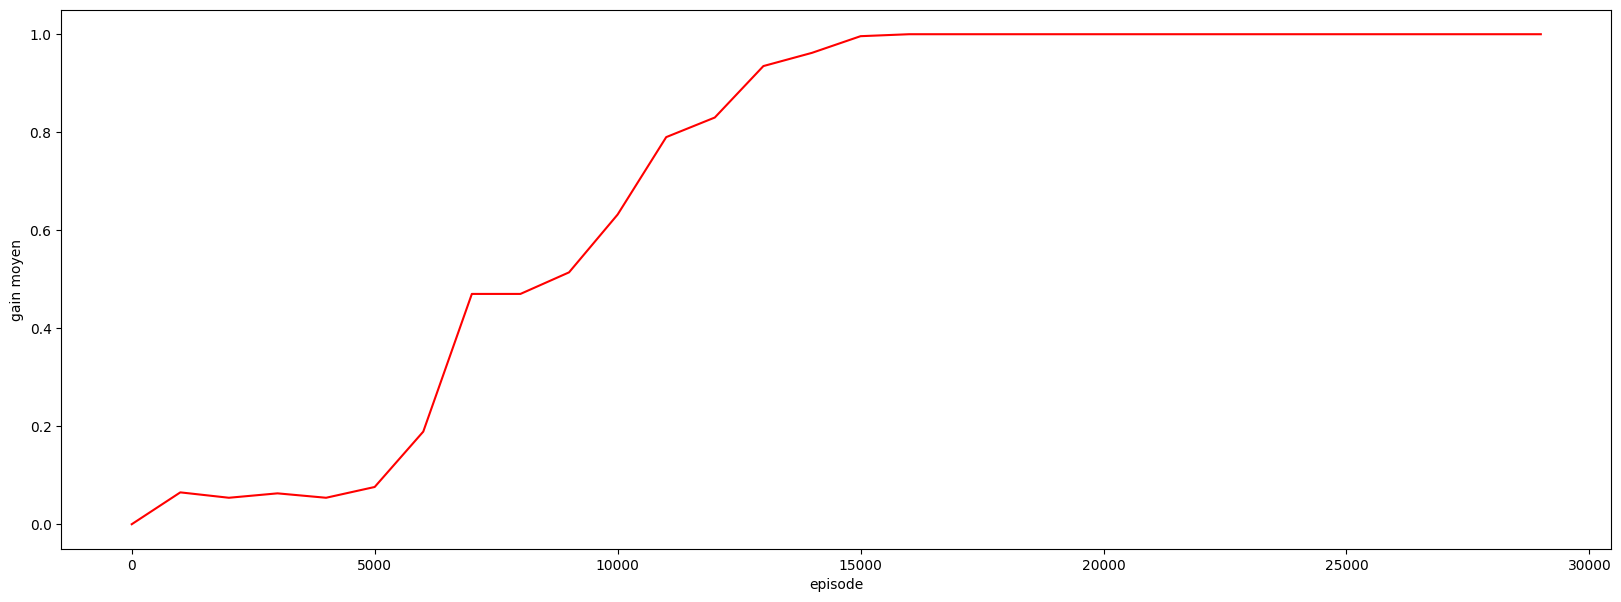

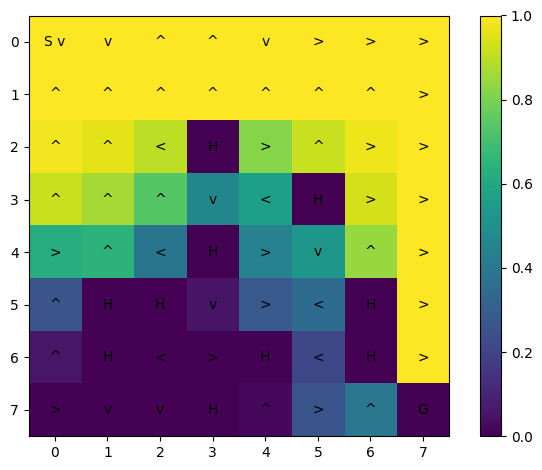

Episode terminé après 142 itérations  moyenne
Récompenses obtenues moyenne: 1.0
MoviePy - Building file FrozenLake_q_learning8x8.gif with imageio.


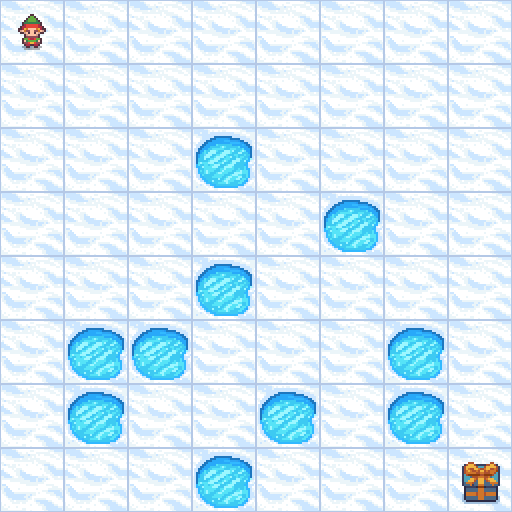

In [32]:
frame=plot(q2_,evaluation2_,8)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("FrozenLake_q_learning8x8.gif", fps=10)
Image(filename="FrozenLake_q_learning8x8.gif")

###### MC on_policy

In [33]:
q3_,evaluation3_=onPolicyMC(1,30000,numStates)

  0%|          | 0/30000 [00:00<?, ?it/s]

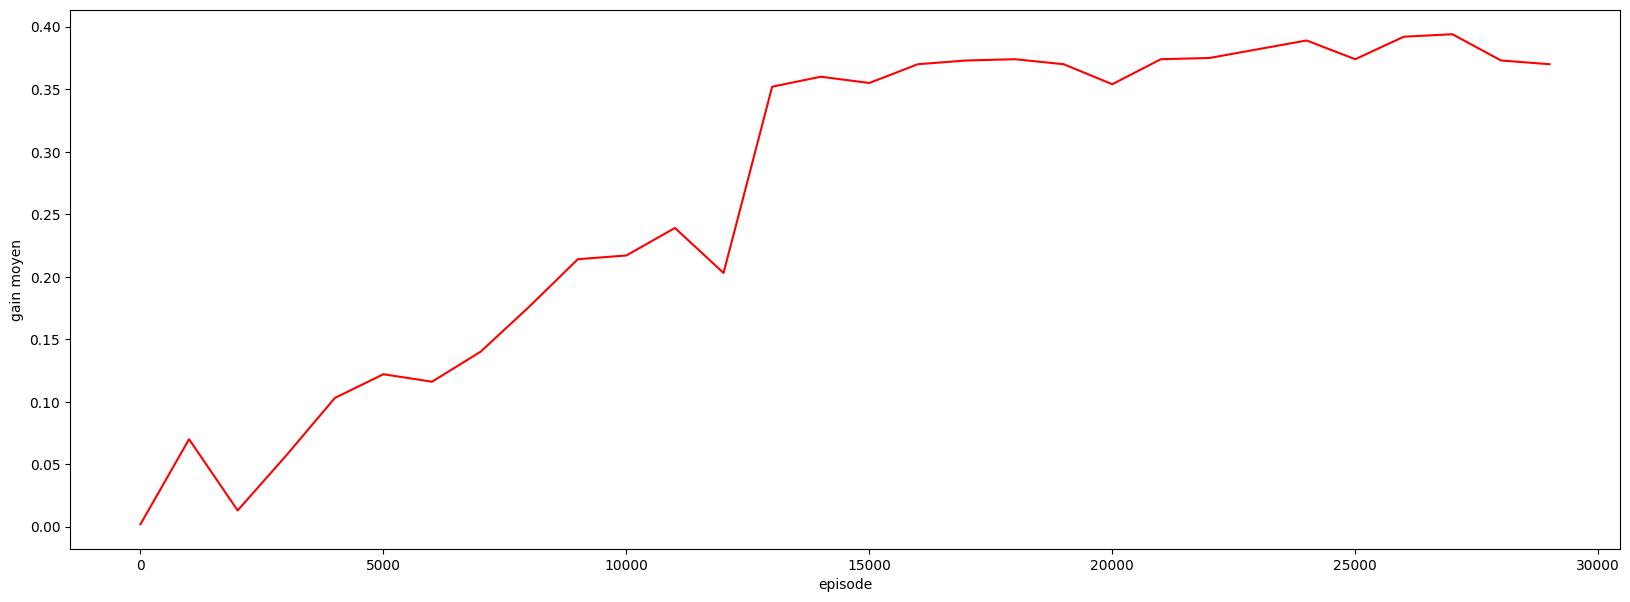

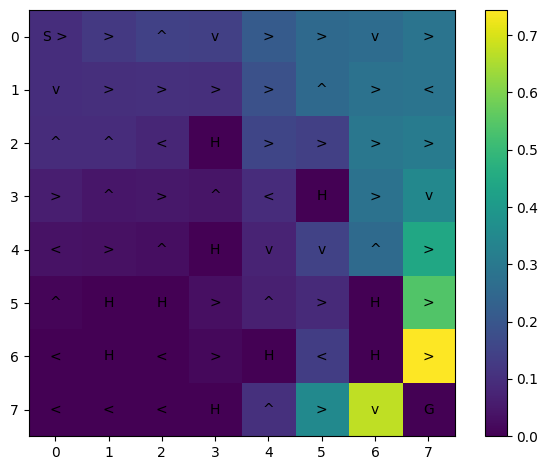

Episode terminé après 53 itérations  moyenne
Récompenses obtenues moyenne: 0.409
MoviePy - Building file FrozenLake_MC.gif with imageio.


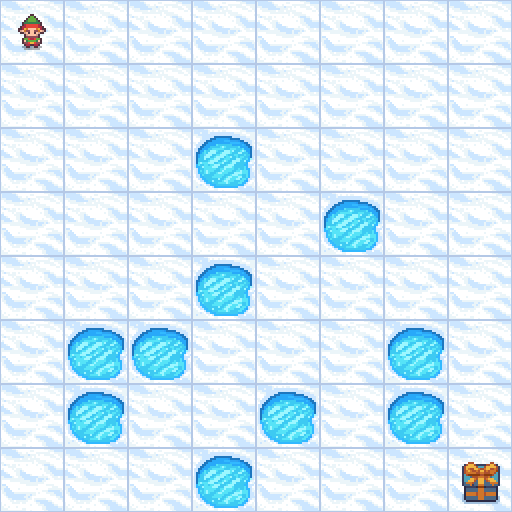

In [34]:
frame=plot(q3_,evaluation3_,8)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("FrozenLake_MC.gif", fps=10)
Image(filename="FrozenLake_MC.gif")

## Comparison

Compare the policies found using SARSA, Q-learning, and you should also be able to use the on policy Monte Carlo algorithm code from the previous TD.

Before convergence to the optimal, we often observe that SARSA has chosen a less risky policy before finding the optimal for the FrozenLake8x8.

#### comparaison pour 4x4

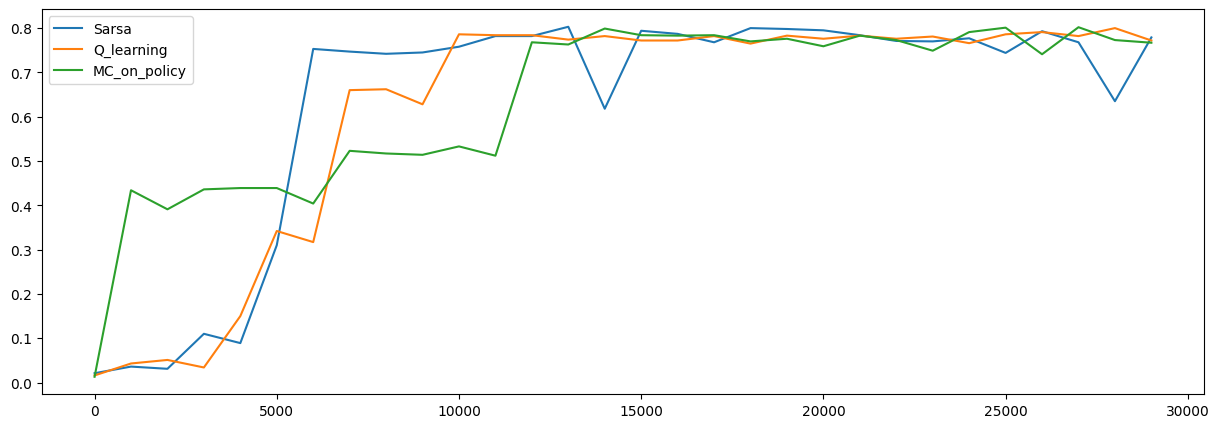

In [35]:
plt.figure(figsize=(15,5))
plt.plot([i * 1000 for i in range(len(evaluation1))],evaluation1)
plt.plot([i * 1000 for i in range(len(evaluation2))],evaluation2)
plt.plot([i * 1000 for i in range(len(evaluation3))],evaluation3)
plt.legend(["Sarsa","Q_learning","MC_on_policy"])

**observations**:
1) On policy MC has the longest convergence

2) sarsa and q learning have similar behavior => same algorithmic complexity (number of iterations)

3) q learning takes longer to run complexity => higher time

#### comparaison pour 8x8

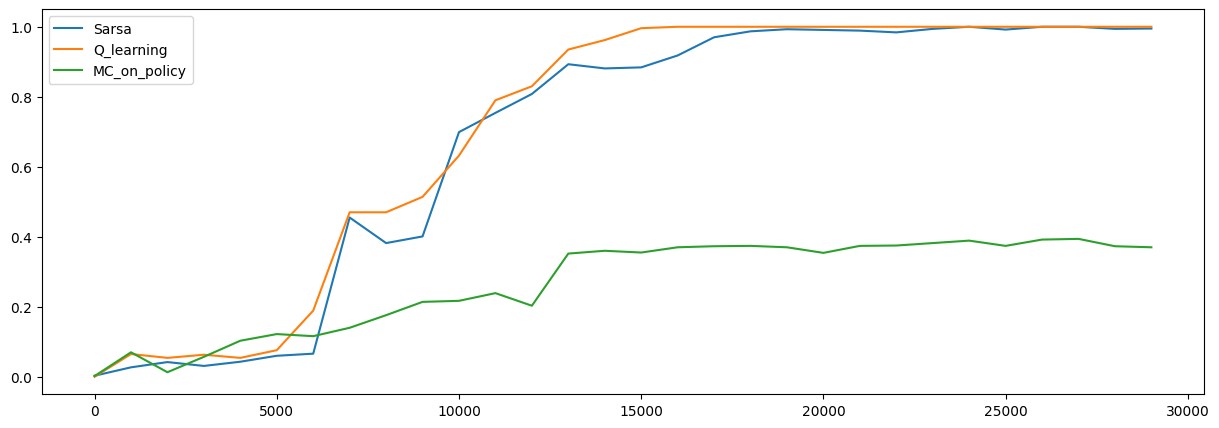

In [36]:
plt.figure(figsize=(15,5))
plt.plot([i * 1000 for i in range(len(evaluation1_))],evaluation1_)
plt.plot([i * 1000 for i in range(len(evaluation2_))],evaluation2_)
plt.plot([i * 1000 for i in range(len(evaluation3_))],evaluation3_)
plt.legend(["Sarsa","Q_learning","MC_on_policy"])

**observations**:
1) On policy MC did not converge for a number 30000 episode because the number of states has increased compared to 4x4 and this algorithm needs to estimate the value q(s,a) of each state-action to find the optimal policy

2) sarsa and q learning have similar behavior => same algorithmic complexity (number of iterations)

3) q learning takes longer to run complexity => higher time

## Cart-pole in tabular

Finally, we suggest that you use your code and test learning on the cart-pole problem. A priori, it is a problem where the states are continuous variables. We suggest here to discretize the variables and try to use one of the methods to see your results.

The reward you get is the number of time steps the stick has remained in balance. If you're using colab to code, unfortunately you won't be able to view an episode with the render method :-(

This Cart-Pole environment consists of moving a cart to balance a beam. More precisely:
* There are two actions: left and right (represented by 0 and 1).
* The received observation (i.e. the state) is a numpy array including 4 variables: the position of the cart, the velocity, the vertical angle and the position of the top of the beam.
* The episode ends when the angle of the vertical beam exceeds 12 degrees.
* The rewards received are equal to 1 unless the angle exceeds 12 degrees.

We give you below the functions to perform the discretization and to encode the state into an integer.

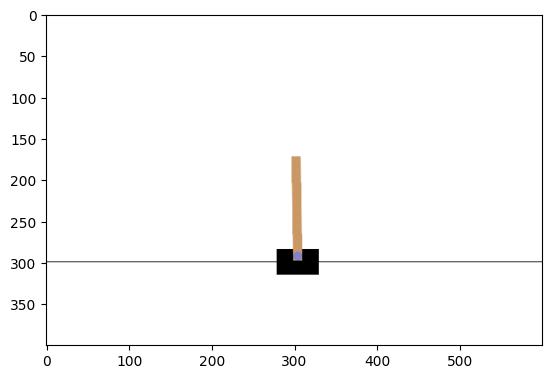

In [37]:
env.close()
env = gym.make("CartPole-v1",render_mode= 'rgb_array')
env.reset()
plt.imshow(env.render())

In [38]:
# print("environnement avec ", env.action_space.n, " actions")
# print("l'espace des états est lui codé avec une class", env.observation_space,
#       " qui représente un espace continu")
# print("les bornes inférieures des intervalles sont: ", env.observation_space.low)
# print("les bornes supérieures des intervalles sont: ",env.observation_space.high)
print("environment with ", env.action_space.n, " actions")
print("the space of states is coded with a class", env.observation_space,
       "which represents a continuous space")
print("the lower bounds of the intervals are: ", env.observation_space.low)
print("the upper bounds of the intervals are: ",env.observation_space.high)
env.reset()
nbr=0
done=False
while not done:
    obs, reward, done,_,_ = env.step(np.random.randint(2))
    nbr+=1
# print("Episode terminé après {} itérations".format(nbr))
print("Episode ended after {} iterations".format(nbr))
env.close()

environnement avec  2  actions
l'espace des états est lui codé avec une class Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)  qui représente un espace continu
les bornes inférieures des intervalles sont:  [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
les bornes supérieures des intervalles sont:  [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
Episode terminé après 28 itérations


In [39]:
state = env.reset()
state

(array([-0.0320705 , -0.0493289 ,  0.00373622,  0.02635513], dtype=float32),
 {})

### discretisation state

In [40]:
def discritiser_range(xmin, xmax, num_bins):
    return np.linspace(xmin, xmax, num_bins + 1)[1:-1]
def discritizer_valeur(value, bins):
    return np.digitize(x=value, bins=bins)
# Discretize the continuous state space for each of the 4 features.


def encode(state):
    L=[]
    for i, feature in enumerate(state):
        L.append(discritizer_valeur(feature, state_bins[i]) * ((max_bins + 1) ** i))
    return(sum(L))

In [41]:
'''def discretise(x,mini,maxi): 
  #discretise x renvoie un entier entre 0 et nval-1
    if x<mini: x=mini
    if x>maxi: x=maxi
    return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))

def encode(observation):
    pos = discretise(observation[0],mini=-1,maxi=1)
    vel = discretise(observation[1],mini=-1,maxi=1)
    angle = discretise(observation[2],mini=-1,maxi=1)
    pos2 = discretise(observation[3],mini=-1,maxi=1)
    return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval
'''

'def discretise(x,mini,maxi): \n  #discretise x renvoie un entier entre 0 et nval-1\n    if x<mini: x=mini\n    if x>maxi: x=maxi\n    return int(np.floor((x-mini)*nval/(maxi-mini+0.0001)))\n\ndef encode(observation):\n    pos = discretise(observation[0],mini=-1,maxi=1)\n    vel = discretise(observation[1],mini=-1,maxi=1)\n    angle = discretise(observation[2],mini=-1,maxi=1)\n    pos2 = discretise(observation[3],mini=-1,maxi=1)\n    return pos + vel*nval + angle*nval*nval + pos2*nval*nval*nval\n'

In [42]:
Nval = 10 # nombre de valeurs discrètes qu’une variable peut prendre

state_bins = [
            discritiser_range(-1, 1, Nval),#-2.4,2.4,
            # Cart velocity.
            discritiser_range(-2, 2, Nval),
            # Pole angle.
            discritiser_range(-0.2095, 0.295, Nval),
            # Tip velocity.
            discritiser_range(-2, 2, Nval)
]



max_bins = max(len(bin) for bin in state_bins)

numStates= (max_bins + 1) ** len(state_bins)

print("The number of states here will be ", numStates)

Le nombre d'états sera ici de  10000


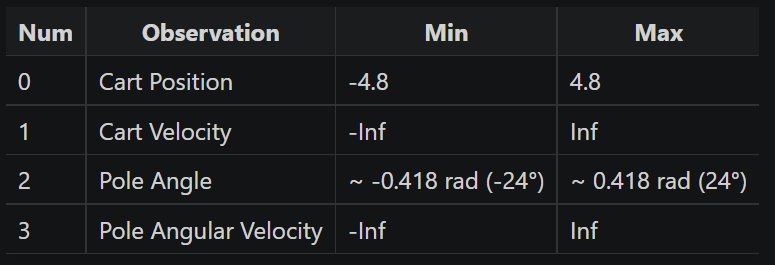

**Carriage's x position (index 0) can take values between (-4.8, 4.8), but the episode ends if the carriage leaves the range (-2.4, 2.4) .**

**The pole angle can be observed between (-.418, .418) radians (or ±24°), but the episode ends if the pole angle is not in the range (-.2095 , .2095) (or ±12°)**

Modify your Q-learning and/or SARSA implementation to test if you can learn to balance the stick. A modification will be to use the functions above to encode/decode a state. Another will surely be to add the number of states as a parameter because this number is now independent of the environment!
With the parameters $\epsilon=0.1$, $\alpha=0.2$ and $\gamma=0.9$, I manage to reach a score around 90 time steps.

**parametre** 
$\epsilon=0.2$, $\alpha=0.02$ et $\gamma=0.9$

###### SARSA

In [43]:
gamma=0.9
nbr=15000
Nombre_etat=numStates
alpha=0.02
eps=0.2
nbr_eval=1000
nbr_iteration=True
eps_variable=False
freq_eval=1000


q_1_,evaluation_1_= sarsa(gamma,nbr,Nombre_etat,alpha,eps,nbr_eval,nbr_iteration,eps_variable,freq_eval)


  0%|          | 0/15000 [00:00<?, ?it/s]

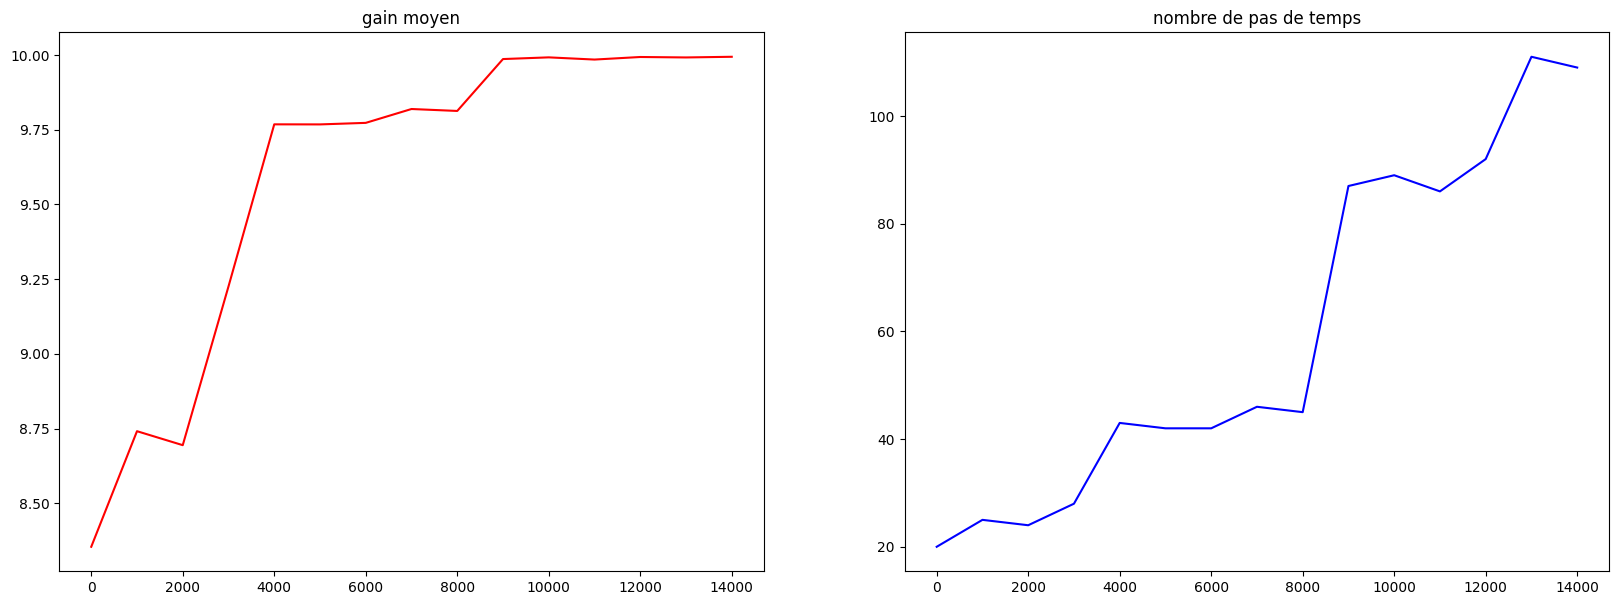

Episode terminé après 124 itérations  moyenne
Récompenses obtenues moyenne: 9.994655916131318
MoviePy - Building file Cart-pole_sarsa.gif with imageio.


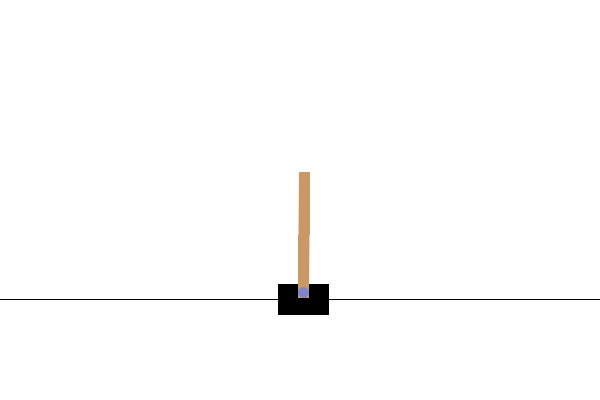

In [44]:
evaluation_1_=np.array(evaluation_1_).reshape(-1,2)
frame=plot(q_1_,evaluation_1_,plot_Q=False,gamma=0.9)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("Cart-pole_sarsa.gif", fps=10)
Image(filename="Cart-pole_sarsa.gif")


###### Q learning

In [45]:
gamma=0.9
nbr=15000
Nombre_etat=numStates
alpha=0.02
eps=0.2
nbr_eval=1000
nbr_iteration=True
eps_variable=False
freq_eval=1000


q_2_,evaluation_2_=Q_learning(gamma,nbr,Nombre_etat,alpha,eps,nbr_eval,nbr_iteration,eps_variable)

  0%|          | 0/15000 [00:00<?, ?it/s]

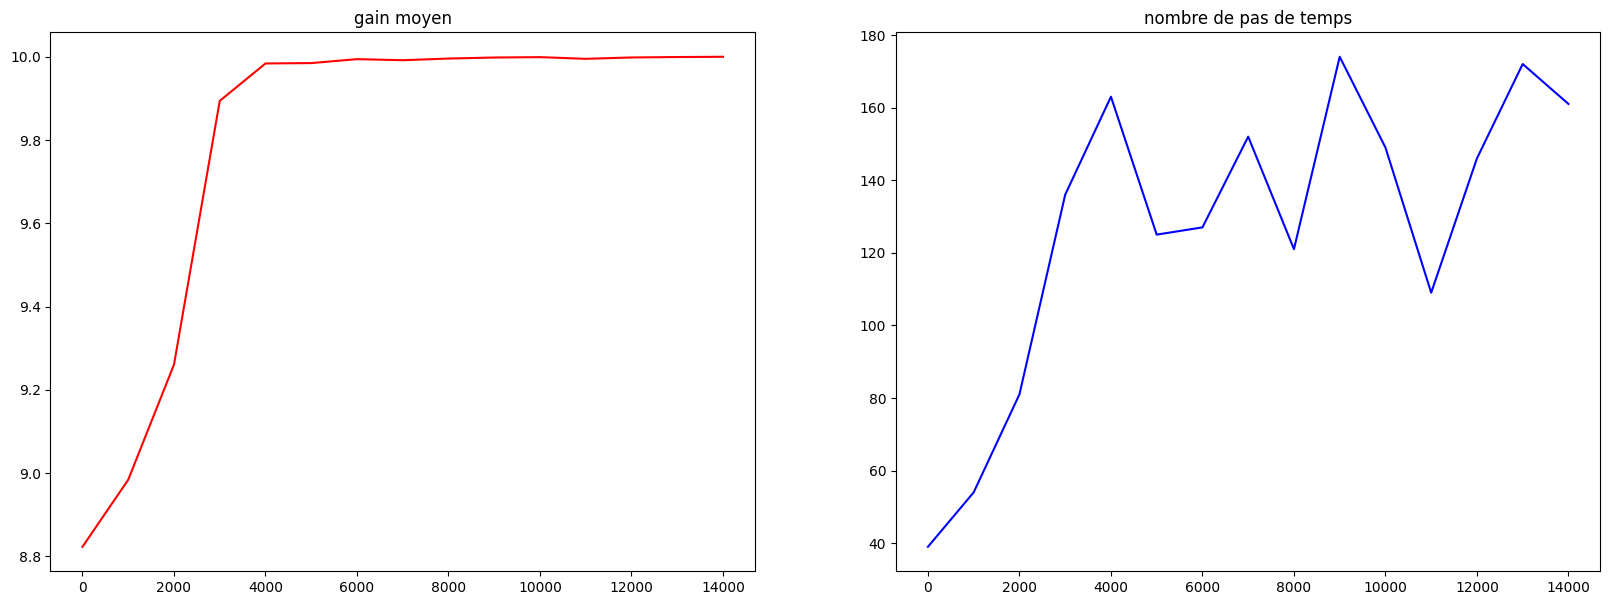

Episode terminé après 227 itérations  moyenne
Récompenses obtenues moyenne: 9.999325576056062
MoviePy - Building file Cart-pole_Q_learning.gif with imageio.


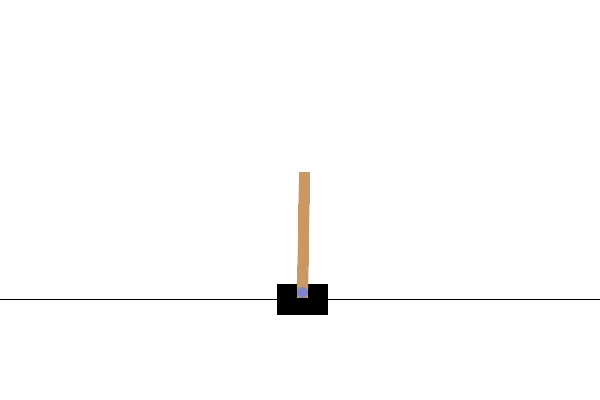

In [46]:
evaluation_2_=np.array(evaluation_2_).reshape(-1,2)

frame=plot(q_2_,evaluation_2_,plot_Q=False,gamma=0.9)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("Cart-pole_Q_learning.gif", fps=10)
Image(filename="Cart-pole_Q_learning.gif")

we have $\gamma=0.9$ so the reward is always increased by
$\sum_{i=0}^{\infty}\gamma^{i}=\frac{1}{1-\gamma}=10$
which is reached with 150 steps (~precision python)
so there will be no further improvement after 150 steps

to have more steps you have to increase $\gamma$

###### on policy

In [47]:
gamma=0.9
nbr=15000
Nombre_etat=numStates
eps=0.2
nbr_eval=1000
nbr_iteration=True
eps_variable=False
freq_eval=1000

q_3_,evaluation_3_=onPolicyMC(gamma,nbr,Nombre_etat,eps,nbr_iteration,eps_variable,freq_eval)


  0%|          | 0/15000 [00:00<?, ?it/s]

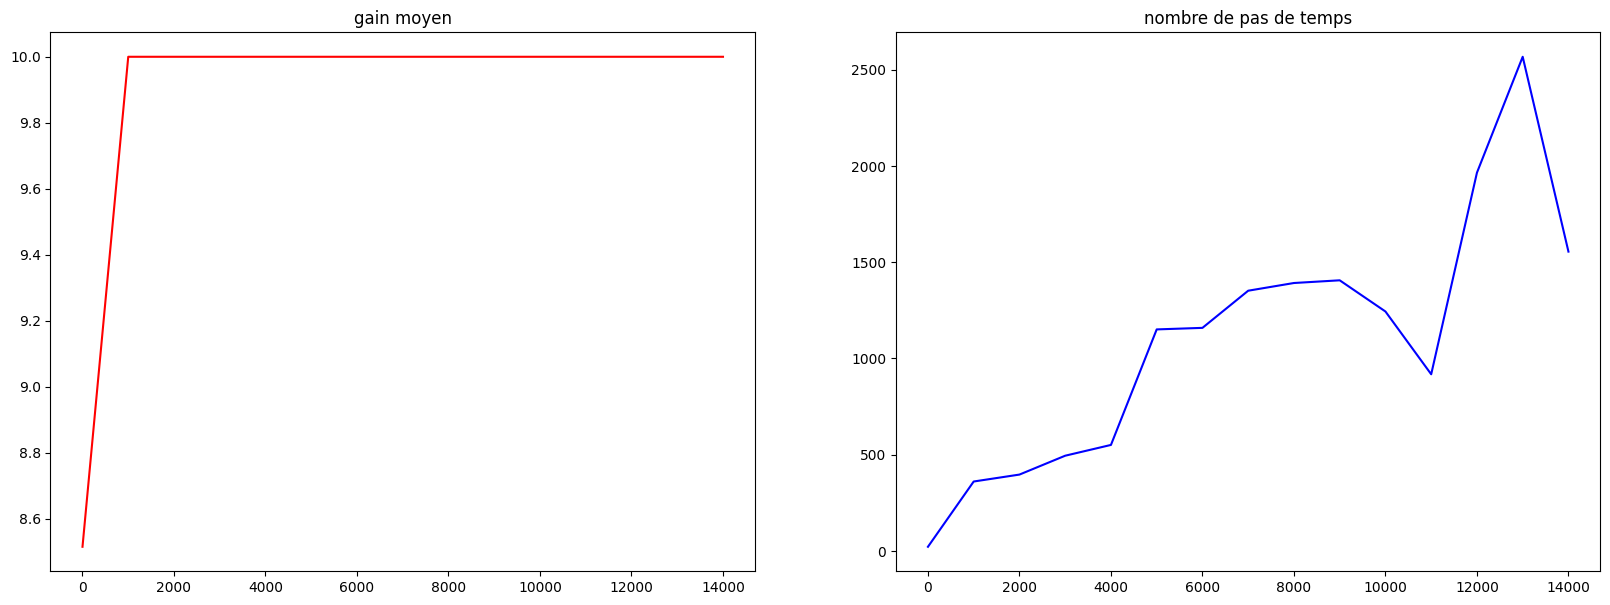

Episode terminé après 1566 itérations  moyenne
Récompenses obtenues moyenne: 9.99999999998143
MoviePy - Building file Cart-pole_MC.gif with imageio.


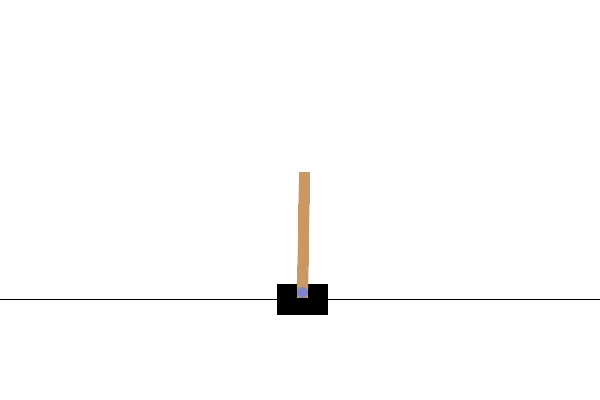

In [48]:
evaluation_3_=np.array(evaluation_3_).reshape(-1,2)

frame=plot(q_3_,evaluation_3_,plot_Q=False,gamma=0.9)
clip=ImageSequenceClip(frame, fps=10).resize(1.0)
clip.write_gif("Cart-pole_MC.gif", fps=10)
Image(filename="Cart-pole_MC.gif")

# Comparaison

Text(0.5, 1.0, 'average gain')

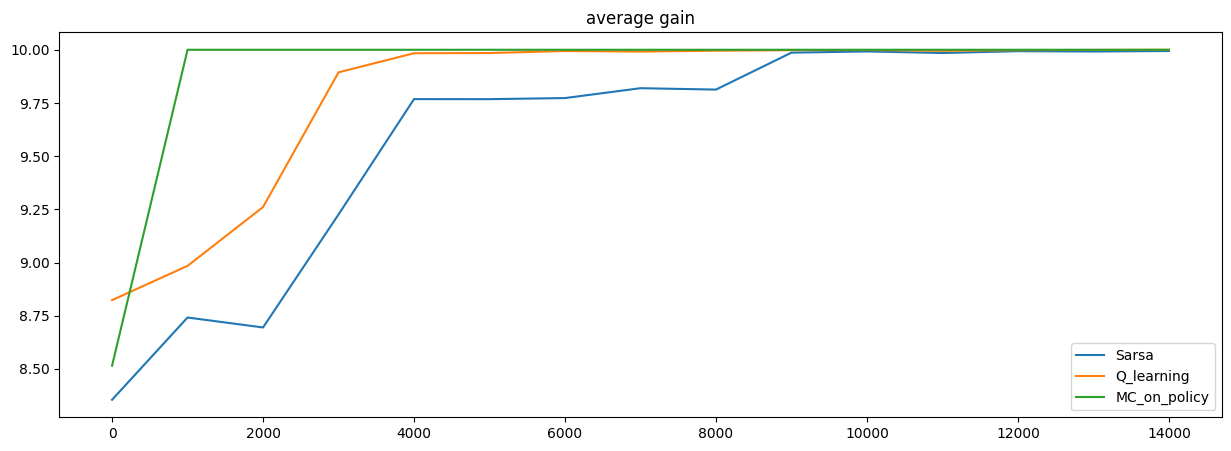

: 

In [52]:
plt.figure(figsize=(15,5))
plt.plot([i * 1000 for i in range(len(evaluation_1_))],evaluation_1_[:,0])
plt.plot([i * 1000 for i in range(len(evaluation_2_))],evaluation_2_[:,0])
plt.plot([i * 1000 for i in range(len(evaluation_3_))],evaluation_3_[:,0])
plt.legend(["Sarsa","Q_learning","MC_on_policy"])
plt.title("average gain")

Text(0.5, 1.0, 'average number of steps')

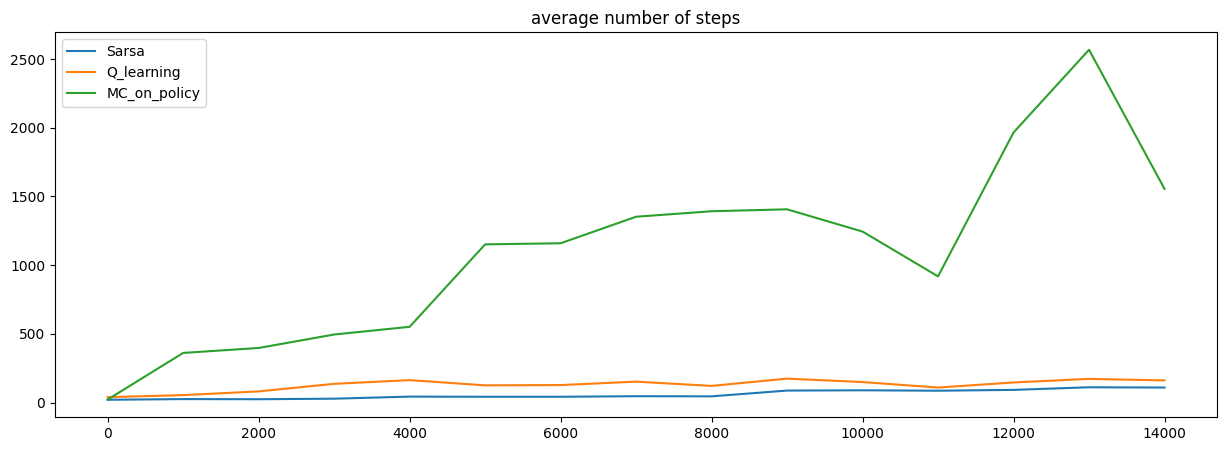

In [51]:
plt.figure(figsize=(15,5))
plt.plot([i * 1000 for i in range(len(evaluation_1_))],evaluation_1_[:,1])
plt.plot([i * 1000 for i in range(len(evaluation_2_))],evaluation_2_[:,1])
plt.plot([i * 1000 for i in range(len(evaluation_3_))],evaluation_3_[:,1])
plt.legend(["Sarsa","Q_learning","MC_on_policy"])
plt.title("average number of steps")

**we notice that monte carlo is the best algorithm in terms of convergence speed and variance**

# Remarques 

we have $\gamma=0.9$ so the reward is always increased by
$\sum_{i=0}^{\infty}\gamma^{i}=\frac{1}{1-\gamma}=10$
which is reached with 150 steps (~precision python)
so there will be no further improvement after 150 steps

to have more steps you have to increase $\gamma$